# Sampling a GP on a sphere

Let's draw some samples from a Gaussian process on a sphere!

In [1]:
# Import a backend.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels
# Import a space and an appropriate kernel.
from geometric_kernels.spaces.hypersphere import Hypersphere
from geometric_kernels.kernels.geometric_kernels import MaternKarhunenLoeveKernel
from geometric_kernels.kernels.feature_maps import deterministic_feature_map_compact, random_phase_feature_map_compact
# import sampler
from geometric_kernels.sampling import sampler

INFO: Using numpy backend


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

Define a manifold and build some grid on it:

In [3]:
# Create a manifold (2-dim sphere).
hypersphere = Hypersphere(dim=2)

In [4]:
_NUM_LATS = 128
_NUM_LONGS = 128

In [5]:
# generate points on a sphere
lats, longs =  np.mgrid[0:2*np.pi:_NUM_LATS*1j, 0:np.pi:_NUM_LONGS*1j]

xs = np.sin(longs) * np.cos(lats)
ys = np.sin(longs) * np.sin(lats)
zs = np.cos(longs)

Xs = np.c_[np.ravel(xs), np.ravel(ys), np.ravel(zs)]

Let's see what we've got:

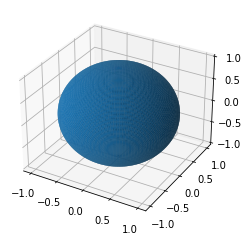

In [6]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xs, ys, zs, cstride=1, rstride=1)

Now, let's define a GP to sample from. To do this, we have to specify a kernel and provide reasonable parameters.

In [7]:
# create a kernel
kernel = MaternKarhunenLoeveKernel(hypersphere, 10)

In [8]:
# initialize kernel with reasonable values
params, state = kernel.init_params_and_state()
params["nu"] = np.array([5/2])
params["lengthscale"] = np.array([0.5])

The kernel $k$ provides a feature map $\phi$ such that $k(x, y) \approx \phi(x)^\top \phi(y)$. 

To draw a sample $f$ from a GP with kernel $k$, we sample standard normal weights $w$ and compute:
$$ f(x) \approx w^\top \phi(x) $$

In `GeometricKernels`, this is abstracted away in the notions of a feature map and a sampler.

In [9]:
# compute feature map for this space and kernel
feature_map = deterministic_feature_map_compact(hypersphere, kernel)

Here, `feature_map` is a function that takes `X`, a point on the sphere, as an input and returns a vector of features. 

Then, we pass `feature_map` to a `sampler`, and the `sampler` produces yet another function that takes `X` along with an optional random state (called `key`) as an input and returns a GP sample evaluated at `X`.

We can also generate more than one sample path at once.

In [10]:
# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

In [11]:
n_samples = 4
sample_paths = sampler(feature_map, s=n_samples)

Now, `sample_paths` is a *deterministic* function of `X`, if we provide the same key. It is not necessary, although recommended, to pass the key.

Let's actually evaluate the sample paths on our spherical grid `Xs` and see what we've got:

In [12]:
key, samples = sample_paths(Xs, params, state, key=key)  # new random state is returned along with the samples

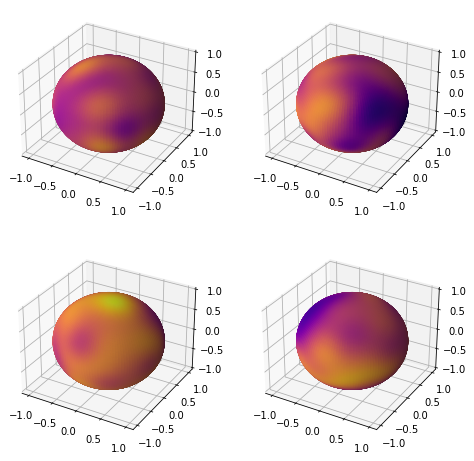

In [13]:
# Plot samples
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=samples.min(), vmax=samples.max())
fig = plt.figure(figsize=(8,8))
for i in range(n_samples):
    sample = samples[:, i].reshape(_NUM_LATS, _NUM_LONGS)
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.plot_surface(xs, ys, zs, facecolors=cmap(norm(sample)), cstride=1, rstride=1)

Now let's try random phase sampling!

In [14]:
rf_feature_map = random_phase_feature_map_compact(hypersphere, kernel)

In [15]:
n_samples = 4
rf_sample_paths = sampler(rf_feature_map, s=n_samples)

In [16]:
key, samples = rf_sample_paths(Xs, params, state, key=key)  # new random state is returned along with the samples

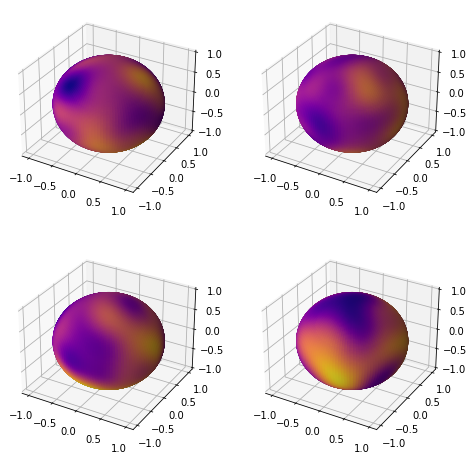

In [17]:
# Plot samples
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=samples.min(), vmax=samples.max())
fig = plt.figure(figsize=(8,8))
for i in range(n_samples):
    sample = samples[:, i].reshape(_NUM_LATS, _NUM_LONGS)
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.plot_surface(xs, ys, zs, facecolors=cmap(norm(sample)), cstride=1, rstride=1)